# HR-аналитика

Компания «Работа с заботой» предоставила данные с характеристиками сотрудников компании. Одной из характеристик сотрудников является уровень удовлетворенности сотрудника работой в компании. Данная характеристики получена при заполнении сотрудниками опросных листов, что является трудоемким процессом. Поэтому требуется построить модель, которая может предсказать уровень удовлетворенности рабочим процессом на основе данных заказчика. Уровень удовлетворенности напрямую влияет на увольнения из компании. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. Второй задачей является предсказание увольнения сотрудника.

*Цели проекта:*
- построить модель, которая предсказывает уровень удовлетворенности сотрудника работой в компании на основе данных заказчика;
- построить модель, которая передсказывает уволится сотрудник из компании, или нет, на основе данных заказчика и предсказаний первой модели. 

*Задачи:*
- загрузить датафреймы;
- выполнить предобработку данных (проверка на пропуски и дубликаты, изменение типов данных);
- исследовательский анализ данных (построение графиков);
- корреляционный анализ данных, исследование признаков на мультиколлинеарность;
- выбор лучшей модели регрессии с использованием пайплайнов;
- получение предсказания уровня удовлетворенности сотрудников работой;
- выбор лучшей модели классификации;
- итоговые выводы.

Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!pip install phik==0.10.0 -q
!pip install scikit-learn==1.3.2 -q
!pip install shap -q
!pip install sklearn_pandas -q

^C


You should consider upgrading via the 'c:\users\79128\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\79128\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\79128\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~hik\\lib\\_phik_simulation_core.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\79128\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\79128\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor as JobSatisfactionRegressor
from catboost import CatBoostClassifier as QuitClassifier
from catboost import cv, Pool
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings

from sklearn_pandas import DataFrameMapper, gen_features
import phik
import shap

## Предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [ ]:
train_job_s = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', index_col='id')
train_job_s.head(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20
405448,hr,middle,low,7,no,no,4,30000,0.78
857135,sales,sinior,medium,9,no,no,3,56400,0.56
400657,purchasing,middle,high,9,no,no,3,52800,0.44
198846,hr,junior,low,1,no,no,2,13200,0.14


In [ ]:
train_job_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [ ]:
test_feature = pd.read_csv('/datasets/test_features.csv', index_col='id')
test_feature.head(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800
429973,purchasing,middle,medium,6,no,no,3,42000
850699,technology,junior,medium,3,no,no,3,26400
500791,sales,middle,high,9,no,no,4,49200
767867,marketing,middle,high,3,no,yes,4,62400


In [ ]:
test_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [ ]:
target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', index_col='id')
target.head(10)

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08
817219,0.76
269033,0.64
962356,0.38
649052,0.14


In [ ]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


Данные загружены в датафреймы pandas: train_job_s (тренировочная выборка), market_money (данные о выручке, которую получает магазин с покупателя), test_feature (входные признаки тестовой выборки), target (целевой признак тестовой выборки). Загруженные данные соответствуют описанию. Названия столбцов соответствуют стандартам, изменение типов данных не требуется. В столбцах dept  level первых двух таблиц есть несколько пропущенных значений. Пропуски будут заполнены в пайплайне.

### Предобработка данных

In [ ]:
#train_job_s = train_job_s.set_index('id')

In [ ]:
train_job_s.duplicated().sum()

245

В тренировочной выборке найдено 245 дублирующих строк. Выполним их удаление.

In [ ]:
train_job_s = train_job_s.drop_duplicates()

In [ ]:
#target = target.set_index('id')
#test_feature = test_feature.set_index('id')

Выполним сортировку датафреймов target и test_feature для того, чтобы у них был одинаковый порядок строк.

In [ ]:
target = target.sort_values(by='id')
test_feature = test_feature.sort_values(by='id')

В ходе предобработки данных были найдены и удалены дублирующие строки в таблице train_job_s. Данные строки не несут пользу при обучении, поэтому оставлять их не имеет смысла. Также была выполнена сортировка датафреймов с тестовыми данными. Это пригодится при получении оценки работы моделей.

### Исследовательский анализ данных

In [ ]:
def build_bar_boxplot(data, column, hist_y_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 5))
    ax1.bar(x = np.sort(data[column].unique()), height = data.groupby(column)['salary'].count())
    fig.suptitle(f'Распределение признака "{column}"', size=20)
    ax1.set_xlabel(column)
    ax1.set_ylabel(hist_y_label)
    ax2.boxplot(x = data[column])
    ax2.set_ylabel(column)
    plt.show()

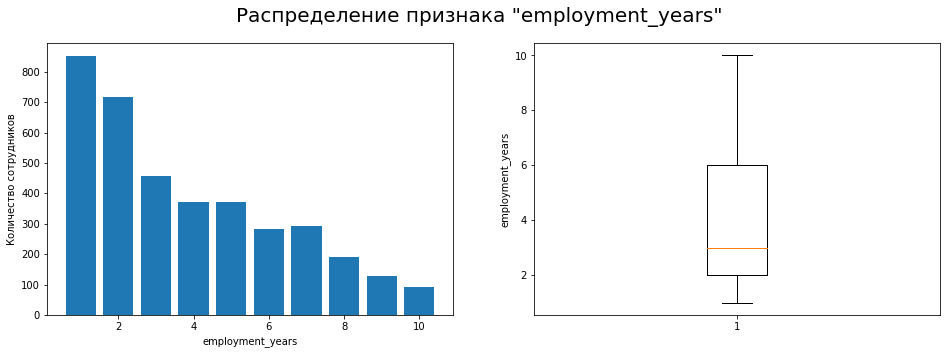

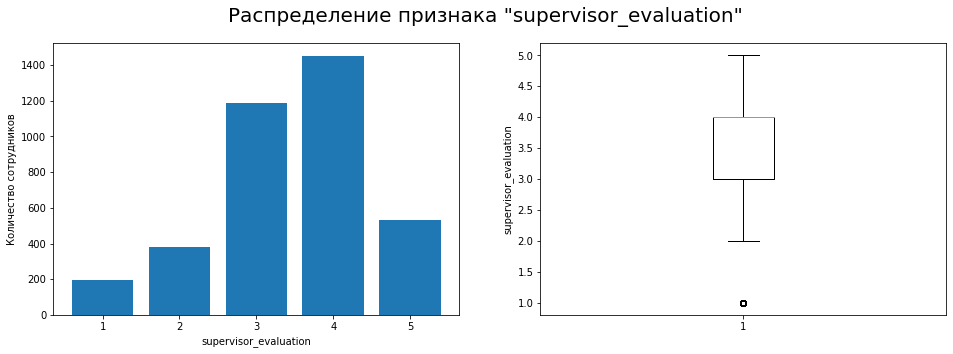

In [ ]:
list_for_bar = ['employment_years', 'supervisor_evaluation']
for item in list_for_bar:
    build_bar_boxplot(train_job_s, item, 'Количество сотрудников')

- 42% сотрудников работают в компании всего 1-2 года;
- 70% сотрудников оценены руководителем на 3-4 балла, только 5% сотрудников имеют оценку "1".

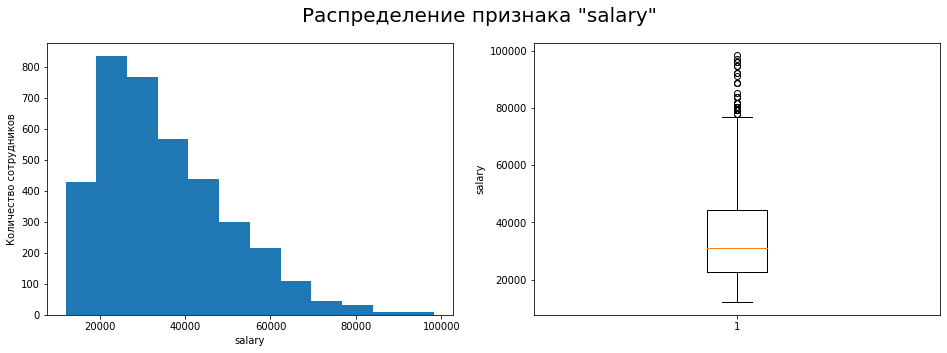

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 5))
ax1.hist(x = train_job_s['salary'], bins = 12)
fig.suptitle(f'Распределение признака "salary"', size=20)
ax1.set_xlabel('salary')
ax1.set_ylabel('Количество сотрудников')
ax2.boxplot(x = train_job_s['salary'])
ax2.set_ylabel('salary')
plt.show()

Медианная зарплата сотрудников 31200. 10% сотрудников получают зарплату ниже 18000, 10% - выше 56400.

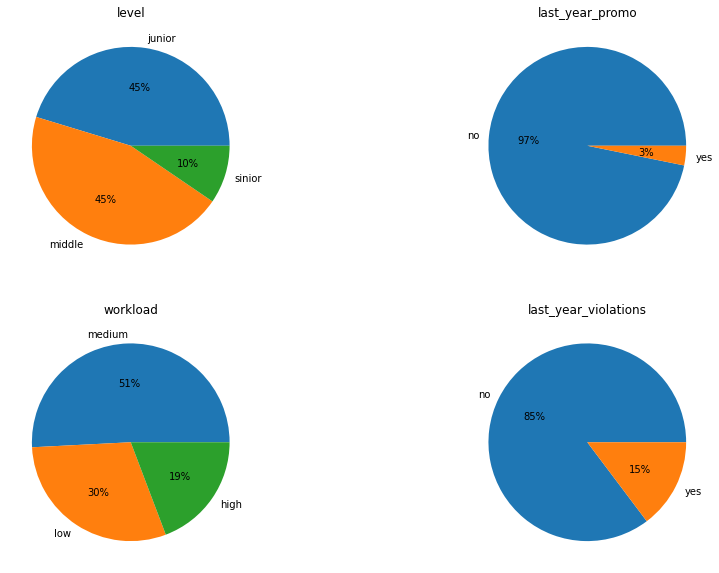

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plot_dict = {'level': ['junior', 'middle', 'sinior'], 'last_year_promo': ['no', 'yes'],
             'workload': ['medium', 'low', 'high'], 'last_year_violations': ['no', 'yes']}
position = 0
for key, value in plot_dict.items():
    row = position // 2
    column = position % 2
    axs[row][column].pie(x=train_job_s[key].value_counts(), autopct='%1.f%%', labels=value)
    axs[row][column].set_title(key)
    position += 1    

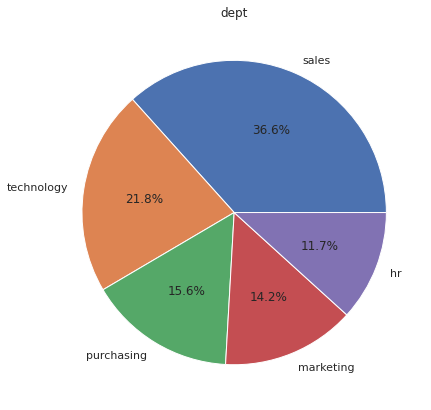

In [ ]:
labels = 'sales', 'technology', 'purchasing', 'marketing', 'hr'
sizes = train_job_s['dept'].value_counts()
sns.set(rc={'figure.figsize':(7,7)})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('dept')
plt.show()

На графиках выше представлено распределение категориальных признаков.

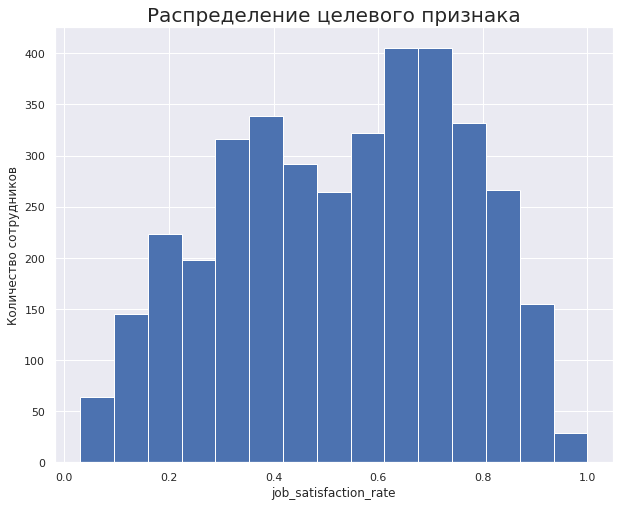

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
ax = train_job_s['job_satisfaction_rate'].plot(kind='hist', bins = 15)
ax.set_xlabel('job_satisfaction_rate')
ax.set_ylabel('Количество сотрудников')
ax.set_title('Распределение целевого признака', size = 20)
plt.show()

Почти 90% значений целевого признака лежат в диапазоне 0.2 - 0.9. По графику видно два пика - 0.4 и 0.7.

In [ ]:
def scatter_plot(x):
    g = sns.pairplot(train_job_s, x_vars=['employment_years', 'supervisor_evaluation', 'salary'], 
                     y_vars=['job_satisfaction_rate'], hue=x, plot_kws={'alpha':0.7})
    g.fig.suptitle(f'Взаимосвязь "satisfaction" и количественных признаков с учетом признака "{x}"', y=1.08, size=20)
    g.fig.set_figheight(4)
    g.fig.set_figwidth(15)
    sns.set_style("whitegrid")
    plt.show()

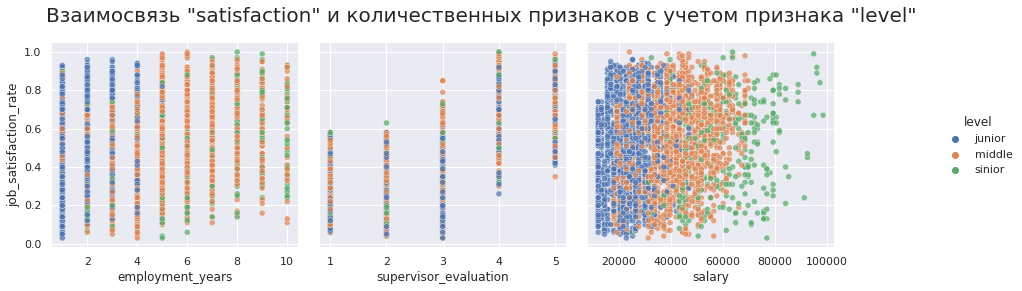

In [ ]:
scatter_plot('level')

- level и employment_years имеют линейную взаимосвязь;
- зависимости между supervisor_evaluation и level по графику не найдено;
- зарплата сотрудников уровня в среднем junior меньше, чем у сотрудников уровня middle. Самые высокие зарплаты у сотрудников с уровнем sinior.

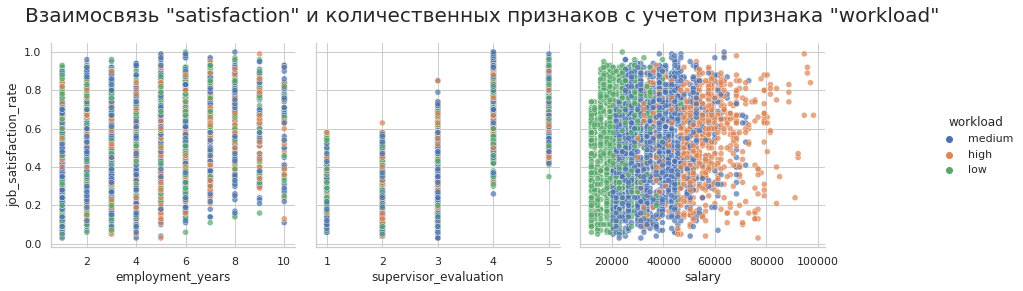

In [ ]:
scatter_plot('workload')

- зависимости между supervisor_evaluation (employment_years) и workload по графику не найдено;
- зарплата у сотрудников с высоким уровнем загруженности больше, чем у сотрудников со средним и низким.

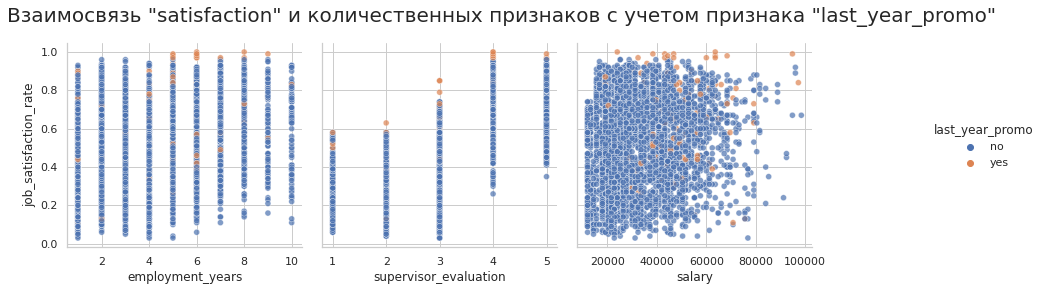

In [ ]:
scatter_plot('last_year_promo')

- больше всего повышений получили сотрудники, работающие в компании 5-6 лет;
- для каждой выставленной руководителем оценки наибольший уровень удовлетворенности работой имеют те сотрудники, у которых было повышение за последний год;
- зависимости между salary и last_year_promo по графику не найдено.

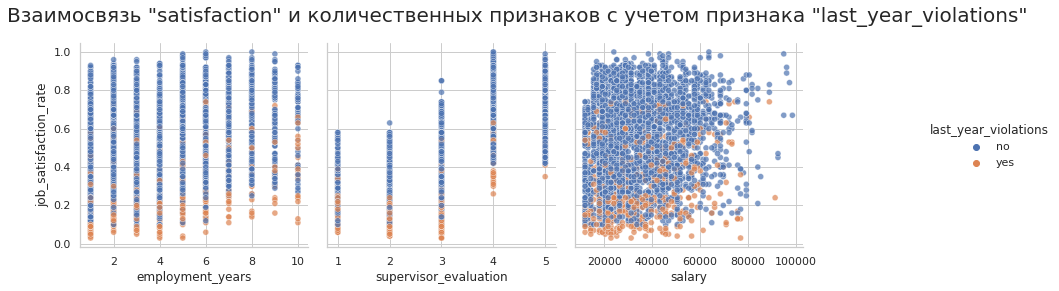

In [ ]:
scatter_plot('last_year_violations')

Люди, нарушавшие трудовой договор в течение последнего года имеют более низкий уровень удовлетворенности работой в компании.

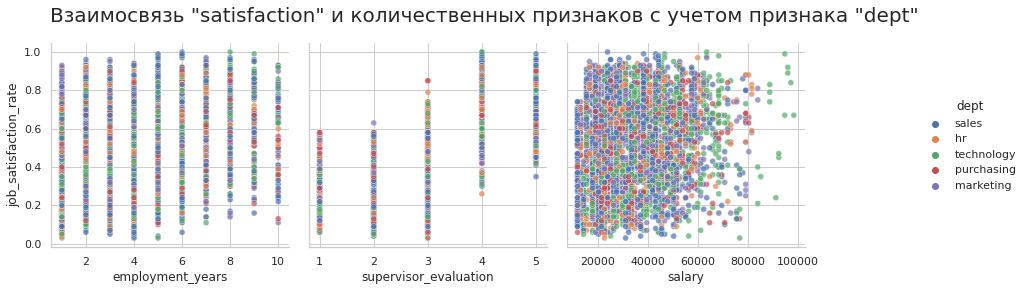

In [ ]:
scatter_plot('dept')

Зависимости между отделом и колличественными признаками по по графику не найдено.

- с повышением оценки руководителя увеличивается уровень удовлетворенности сотрудников работой;
- уровень заработной платы в целом не влияет на целевой признак, однако, при очень низкой зарплате нет высоких показателей job_satisfaction_rate, а при высокой з/п нет низких показателей job_satisfaction_rate;
- у сотрудников с большим значением employment_years отсутствуют экстремально низкие показатели целевого признака.

In [ ]:
sns.set(rc={'figure.figsize':(12,9)})
interval_cols = ['salary', 'job_satisfaction_rate']

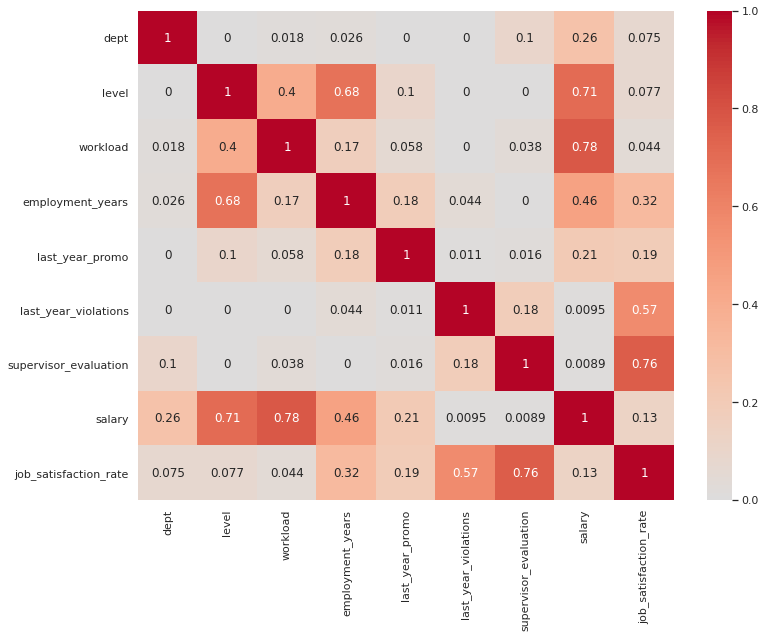

In [ ]:
sns.heatmap(train_job_s.phik_matrix(interval_cols=interval_cols), cmap='coolwarm', center=0, annot=True)
plt.show()

Целевой признак имеет сильную корреляцию с признакам supervisor_evaluation и last_year_violation.
С признаками dept, level, workload корреляция слабая. Мультиколлинеарности в данных нет.

Оценим распределение признаков в тестовой выборке

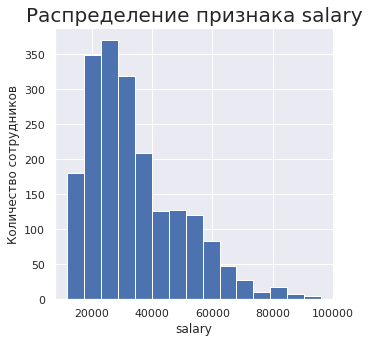

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
ax = test_feature['salary'].plot(kind='hist', bins = 15)
ax.set_xlabel('salary')
ax.set_ylabel('Количество сотрудников')
ax.set_title('Распределение признака salary', size = 20)
plt.show()

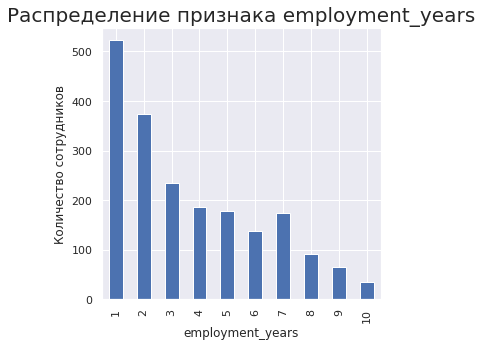

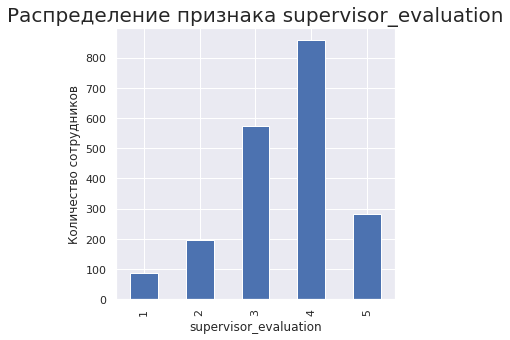

In [ ]:
for item in ['employment_years', 'supervisor_evaluation']:
    sns.set(rc={'figure.figsize':(5,5)})
    ax = test_feature.groupby(item)['salary'].count().plot(kind='bar')
    ax.set_xlabel(item)
    ax.set_ylabel('Количество сотрудников')
    ax.set_title(f'Распределение признака {item}', size = 20)
    plt.show()

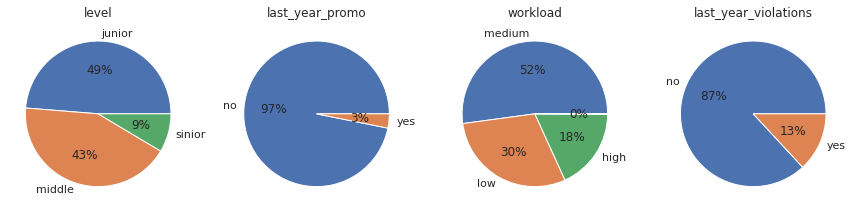

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plot_dict = {'level': ['junior', 'middle', 'sinior'], 'last_year_promo': ['no', 'yes'],
             'workload': ['medium', 'low', 'high', ' '], 'last_year_violations': ['no', 'yes']}
column = 0
row = 1
for key, value in plot_dict.items():
    axs[column].pie(x=test_feature[key].value_counts(), autopct='%1.f%%', labels=value)
    axs[column].set_title(key)
    column += 1

Распределение признаков тестового датесета похоже на распределение признаков тренировочного.

Для обучения моделей исключим из тренировочной выборки информацию об отделе.

In [ ]:
X_train = train_job_s.drop(['job_satisfaction_rate', 'dept'], axis=1)
y_train = train_job_s['job_satisfaction_rate']

### Подготовка данных

Проверка качества моделей будет осуществляться на основе метрики SMAPE.

<font size="4"> $SMAPE = \frac{100}{n}  \sum _{i=1}  ^{n} \frac{|y_i - y`_i|}{(|y_i| + |y`_i|)/2}$

Так как в sklearn.metrics отсутствует реализация данной метрики, она написана самотоятельно.

In [ ]:
def smape(y_true, y_pred):
    return 100 / len(y_true) * sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

scorer = make_scorer(smape, greater_is_better=False) 

In [ ]:
RANDOM_STATE = 1

Выполним подготовку данных к обучению модели. Для кодирования категориальных переменных будем использовать OneHotEncoder (для признаков last_year_violations и last_year_promo) и OrdinalEncoder (для признаков workload и level). Перед кодированием выполняется работа с пропусками - замена их на самое популярное значение в данном столбце. Для числовых колонок с помощью RandomizedSearchCV подбирается оптимальная стратегия: масштабирование с помощью StandardScaler, MinMaxScaler или отсутствие масштабирования. 

In [ ]:
ohe_columns = ['last_year_violations', 'last_year_promo']
ord_columns = ['workload', 'level']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'],
                    ['junior', 'middle', 'sinior'],
                 ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

При помощи RandomizedSearchCV подберем лучшие гиперпараметры для обучения.

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(7, 9),
        'models__max_features': range(6, 8),
        'models__max_leaf_nodes': range(75,80),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -1 * randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                           

In [ ]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strate...
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'sinior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=8, max_features=7,
                                       max_leaf_nodes=77, random_state=1))])

Лучшие результаты на тренировочной выборке дает модель DecisionTreeRegressor(max_depth=8, max_features=7, max_leaf_nodes=77), масштабирование количественных признаков при помощи StandardScaler. Оценка на кросс-валидации 17.6         

Обучим модель CatBoostRegressor. Предварительно заполним пропуски в тренировочной и тестовой выборках. Другую подготовку данных не выполняем.

In [ ]:
cat_features = [['last_year_violations'], ['last_year_promo'], ['dept'], ['workload'], ['level']]

In [ ]:
else_column = [['employment_years'], ['supervisor_evaluation'], ['salary']]

In [ ]:
cat_f = ['last_year_violations', 'last_year_promo', 'dept', 'workload', 'level']

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
y = ['job_satisfaction_rate']
X = [col for col in train_job_s if col not in y]

In [ ]:
class SMAPEMetric(object):
    def get_final_error(self, error, weight):
        return (100 / (weight) * error)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            #w = 1.0 if weight is None else weight[i]
            weight_sum += 1
            error_sum += 2 * np.abs(approx[i] - target[i]) / (np.abs(approx[i]) + np.abs(target[i]))

        return error_sum, weight_sum

In [ ]:
params = {
    'iterations': 950,
    'learning_rate': 0.1,
    'eval_metric': SMAPEMetric(),
    'random_seed': RANDOM_STATE,
    'loss_function': 'RMSE',
    'verbose': 100
}

In [ ]:
gen_category = gen_features(
    columns=cat_features,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "most_frequent"
        }
    ]
)

gen_category = [(col_name[0], col_name[1], {"alias": col_name[0][0]}) for col_name in gen_category]

In [ ]:
num_category = gen_features(
    columns=else_column,
    classes=[

    ]
)

num_category = [(col_name[0], col_name[1], {"alias": col_name[0][0]}) for col_name in num_category]

In [ ]:
preprocess_mapper = DataFrameMapper(
    [
        *gen_category,
        *num_category
    ],
    input_df=True,
    df_out=True
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess_mapper),
    ("estimator", JobSatisfactionRegressor(**params))
])

pipeline.fit(train_job_s[X], train_job_s[y], estimator__cat_features=cat_f)

0:	learn: 37.7463295	total: 572ms	remaining: 9m 2s
100:	learn: 13.5394620	total: 882ms	remaining: 7.42s
200:	learn: 11.6219273	total: 1.15s	remaining: 4.3s
300:	learn: 10.7860741	total: 1.42s	remaining: 3.07s
400:	learn: 10.2594473	total: 1.68s	remaining: 2.31s
500:	learn: 9.8232465	total: 1.95s	remaining: 1.75s
600:	learn: 9.4510883	total: 2.21s	remaining: 1.28s
700:	learn: 9.1779761	total: 2.47s	remaining: 878ms
800:	learn: 8.9386970	total: 2.75s	remaining: 511ms
900:	learn: 8.7398697	total: 3.02s	remaining: 164ms
949:	learn: 8.6382122	total: 3.15s	remaining: 0us


Pipeline(steps=[('preprocess',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['last_year_violations'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'last_year_violations'}),
                                           (['last_year_promo'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'last_year_promo'}),
                                           (['dept'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'dept'}),
                                           (['wo...
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'workload'}),
                                           (['level'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'level'}),
                                           (['employment_years'], None,
                                            {'alias': 'employment_years'}),
                                           (['supervisor_evaluation'], None,
                                            {'alias': 'supervisor_evaluation'}),
                                           (['salary'], None,
                                            {'alias': 'salary'})],
                                 input_df=True)),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x7fe8bf3c0c40>)])

In [51]:
cv_data = cv(
    params=params,
    pool=Pool(pipeline['preprocess'].transform(train_job_s), train_job_s[y], cat_features=cat_f),
    fold_count=5, 
    shuffle=True,
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)
cv_data[cv_data['test-SMAPEMetric-mean'] == cv_data['test-SMAPEMetric-mean'].min()]['test-SMAPEMetric-mean']

Training on fold [0/5]



bestTest = 11.77336959
bestIteration = 948

Training on fold [1/5]



bestTest = 11.78568906
bestIteration = 932

Training on fold [2/5]



bestTest = 11.8590076
bestIteration = 683

Training on fold [3/5]



bestTest = 12.48857129
bestIteration = 922

Training on fold [4/5]



bestTest = 11.24147089
bestIteration = 615



930    11.86306
Name: test-SMAPEMetric-mean, dtype: float64

Оценка модели на кросс-валидации 11.86.

In [ ]:
metric = -1 * scorer(pipeline, train_job_s[X], train_job_s['job_satisfaction_rate'])
metric

9.866091761960922

Оценка модели на тренировочной выборке 9.87.

In [ ]:
metric = -1 * scorer(pipeline, test_feature, target['job_satisfaction_rate'])
metric

10.614700042419033

Метрика SMAPE для данной модели на тестовой выборке равна 10.6, что является хорошим значением. Выполним анализ остатков.

In [ ]:
predictions = pipeline.predict(test_feature)

In [52]:
def analize_difference(y_test, predictions):
    residuals = y_test - predictions

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество записей')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.subplots_adjust(wspace=0.3)
    plt.show()

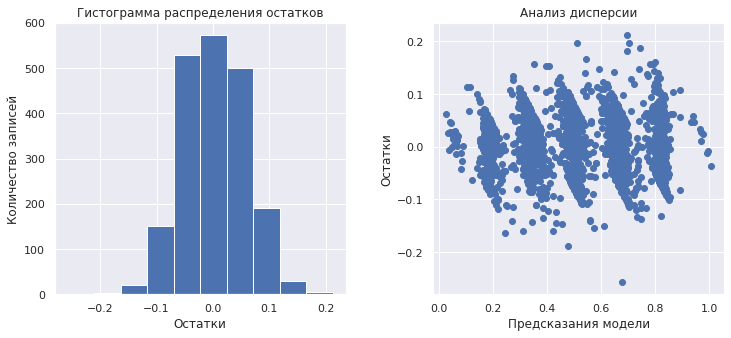

In [53]:
analize_difference(target['job_satisfaction_rate'], predictions)

Гистограмма распределения остатков показывает распределение, близкое к нормальному с центром в нуле. На графике дисперсии видно равномерное распределение ошибок предсказания. В 90% случаев остатки находятся в диапазоне от -0.1 до 0.1. Что говорит о стабильной хорошей работе модели.

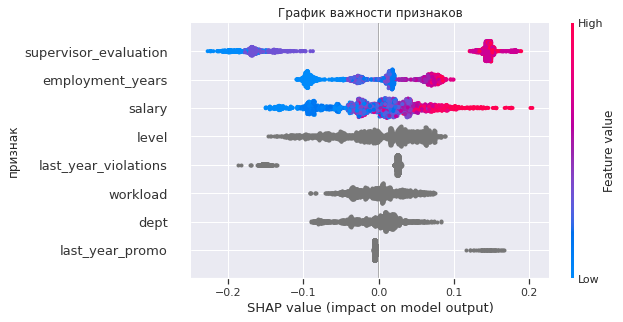

In [54]:
explainer = shap.TreeExplainer(pipeline["estimator"])
shap_values = explainer(pipeline["preprocess"].transform(test_feature))
shap.plots.beeswarm(shap_values, show=0)
plt.title('График важности признаков')
plt.ylabel('признак')
plt.show()

Наиболее важными признаками являются supervisor_evaluation, employment_years и salary. Данные признаки имеют прямую зависимость с целевым. Таким образом, сотрудники с высокой оценкой от руководителя, длительным сроком работы и высоким уровнем з/п имеют более высокую удовлетворенность работой в компании.

### Выводы

Были обучены модели DecisionTreeRegressor, LinearRegression и CatBoostRegressor. Лучшее значение метрики SMAPE имеет модель CatBoostRegressor. В этом нет ничего удивительного, потому что это state of art модель, в отличие от остальных.

## Предсказание увольнения сотрудника из компании

### Загрузка данных

In [55]:
train_quit = pd.read_csv('/datasets/train_quit.csv', index_col='id')
train_quit.head(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no
699916,sales,junior,low,1,no,yes,3,18000,yes
417070,technology,middle,medium,8,no,no,2,44400,no
165489,sales,middle,low,4,no,no,5,19200,no
996399,marketing,middle,low,7,no,no,4,25200,no


In [56]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


In [57]:
test_quit = pd.read_csv('/datasets/test_target_quit.csv', index_col='id')
test_quit.head(10)

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes
223063,no
810370,no
998900,no
578329,no


In [58]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


Данные загружены в датафреймы pandas: train_quit (тренировочная выборка), test_quit (целевой признак тестовой выборки). Загруженные данные соответствуют описанию. Названия столбцов соответствуют стандартам, изменение типов данных не требуется. Пропусков в таблицах нет.

### Предобработка данных

In [59]:
test_quit = test_quit.sort_values(by='id')

In [60]:
train_quit.duplicated().sum()

1413

In [61]:
train_quit = train_quit.drop_duplicates()

In [62]:
test_feature['job_satisfaction_rate'] = predictions

В ходе предобработки данных были найдены и удалены дублирующие строки в таблице train_quit. В новых датафремах в качестве индекса установлен id. Выполнена сортировка датафрейма test_quit, в датафрейм test_feature добавлен столбец job_satisfaction_rate со значениями, предсказанными моделью в предыдущей задаче.

### Исследовательский анализ данных

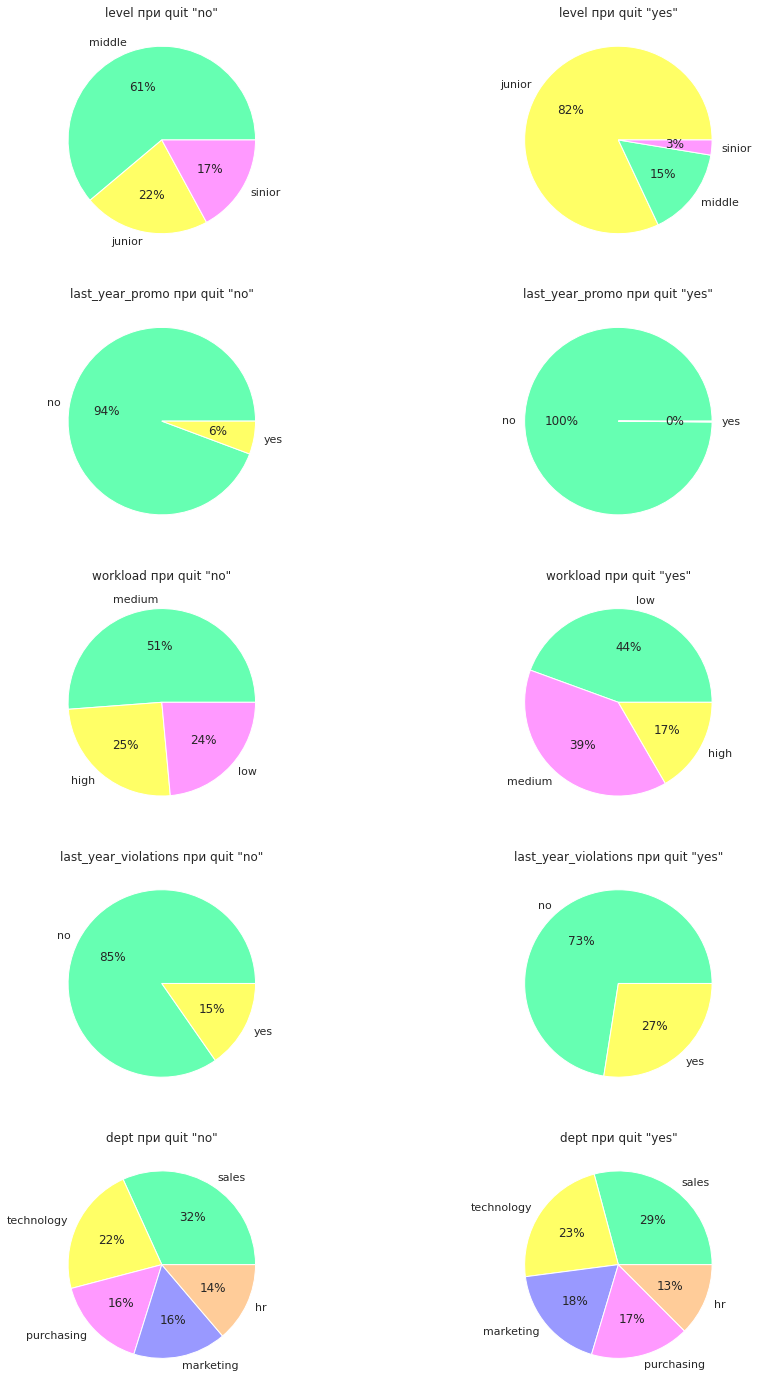

In [63]:
fig, axs = plt.subplots(5, 2, figsize=(15, 25))
plot_dict = {'level': [['middle', 'junior', 'sinior'], ['junior', 'middle', 'sinior'], 
                       ['#66FFB2', '#FFFF66', '#FF99FF'], ['#FFFF66', '#66FFB2', '#FF99FF']],
             'last_year_promo': [['no', 'yes'], ['no', 'yes'],
                                ['#66FFB2', '#FFFF66'], ['#66FFB2', '#FFFF66']],
             'workload': [['medium', 'high', 'low'], ['low', 'medium', 'high'],
                         ['#66FFB2', '#FFFF66', '#FF99FF'], ['#66FFB2', '#FF99FF', '#FFFF66']],
             'last_year_violations': [['no', 'yes'], ['no', 'yes'],
                                     ['#66FFB2', '#FFFF66'], ['#66FFB2', '#FFFF66']],
             'dept': [['sales', 'technology', 'purchasing', 'marketing', 'hr'],
                      ['sales', 'technology', 'marketing', 'purchasing', 'hr'],
                     ['#66FFB2', '#FFFF66', '#FF99FF', '#9999FF', '#FFCC99'], 
                      ['#66FFB2', '#FFFF66', '#9999FF', '#FF99FF', '#FFCC99']]}
row = 0
column = 0
for key, value in plot_dict.items():
    for quit in ['no', 'yes']:
        if quit == 'no':
            labels = value[0]
            colors = value[2]
        else:
            labels = value[1]
            colors = value[3]
        axs[row][column].pie(x=train_quit.loc[train_quit['quit'] == quit, key].value_counts(), 
                             autopct='%1.f%%', labels=labels, colors=colors)
        axs[row][column].set_title(f'{key} при quit "{quit}"')
        column += 1
    row += 1 
    column = 0

- чаще всего из компании увольняются сотрудники с уровнем junior;
- сотрудники, у которых было повыщение за последний год, обычно не увольняются;
- сотрудники с высокой нагрузкой реже увольняются. Скорее всего это связано с уровнем зарплаты;
- среди уволившихся сотрудников выше процент имеющих нарушения трудового договора за последний год;
- сотрудники равномерно удаляются из всех отделов.

In [64]:
train_quit.loc[train_quit['quit'] == 'yes', 'supervisor_evaluation'].value_counts()

3    272
4    148
2    123
1     69
5     43
Name: supervisor_evaluation, dtype: int64

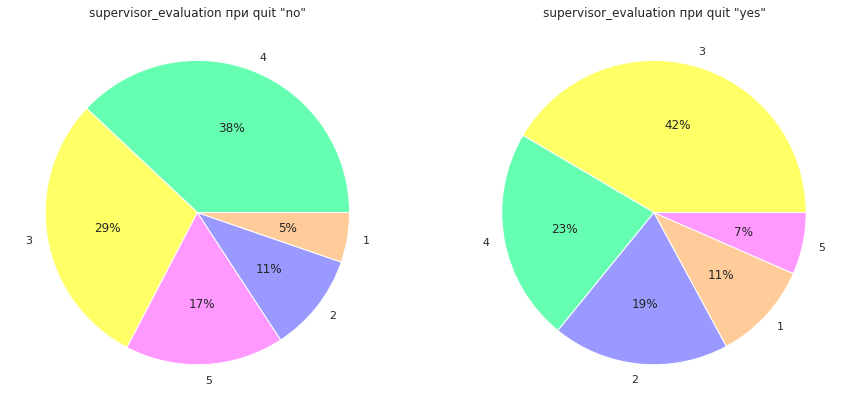

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(15, 25))
plot_dict = {'supervisor_evaluation': [['4', '3', '5', '2', '1'], ['3', '4', '2', '1', '5'], 
                       ['#66FFB2', '#FFFF66', '#FF99FF', '#9999FF', '#FFCC99'], 
                       ['#FFFF66', '#66FFB2', '#9999FF', '#FFCC99', '#FF99FF']]
             }
column = 0
for key, value in plot_dict.items():
    for quit in ['no', 'yes']:
        if quit == 'no':
            labels = value[0]
            colors = value[2]
        else:
            labels = value[1]
            colors = value[3]
        axs[column].pie(x=train_quit.loc[train_quit['quit'] == quit, key].value_counts(), 
                             autopct='%1.f%%', labels=labels, colors=colors)
        axs[column].set_title(f'{key} при quit "{quit}"')
        column += 1


Большая часть уволившихся сотрудников имеет оценки 3 и 4 (эти оценки также являются самыми распространенными в общей выборке). Среди уволившихся сотрудников выше процент 1 и 2.

In [66]:
def build_bar(data, column, y_label):
    plt.bar(x = np.sort(data.loc[data['quit'] == 'yes', column].unique()),
            height = data.loc[data['quit'] == 'yes', column].value_counts(normalize=True).sort_values(ascending=False),
           alpha=0.5, label='yes')
    plt.bar(x = np.sort(data.loc[data['quit'] == 'no', column].unique()),
            height = data.loc[data['quit'] == 'no', column].value_counts(normalize=True).sort_values(ascending=False),
           alpha=0.5, label='no')
    plt.legend(loc='upper right')
    plt.title(f'Распределение признака "{column}"', size=15)
    plt.ylabel(y_label)
    plt.xlabel(column)
    plt.show()

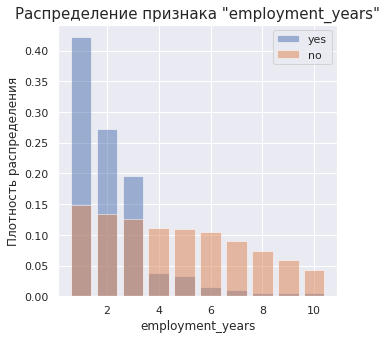

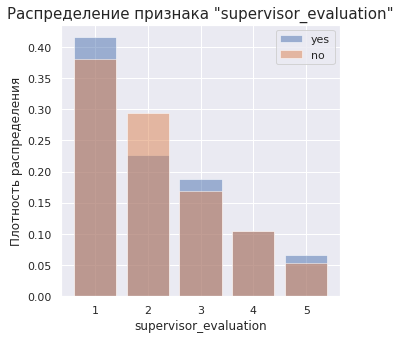

In [67]:
list_for_bar = ['employment_years', 'supervisor_evaluation']
for item in list_for_bar:
    build_bar(train_quit, item, 'Плотность распределения')

Чаще всего увольняются сотрудники, проработавшие не более 3 лет.

In [68]:
def build_bar(data, column, level, y_label):
    plt.bar(x = np.sort(data.loc[(data['quit'] == 'yes') & (data['level'] == level), column].unique()),
            height = data.loc[(data['quit'] == 'yes') & (data['level'] == level), column].value_counts(normalize=True).sort_values(ascending=False),
           alpha=0.5, label='yes')
    plt.bar(x = np.sort(data.loc[(data['quit'] == 'no') & (data['level'] == level), column].unique()),
            height = data.loc[(data['quit'] == 'no') & (data['level'] == level), column].value_counts(normalize=True).sort_values(ascending=False),
           alpha=0.5, label='no')
    plt.legend(loc='upper right')
    plt.title(f'Распределение признака "{column}" для {level}', size=15)
    plt.ylabel(y_label)
    plt.xlabel(column)
    plt.show()

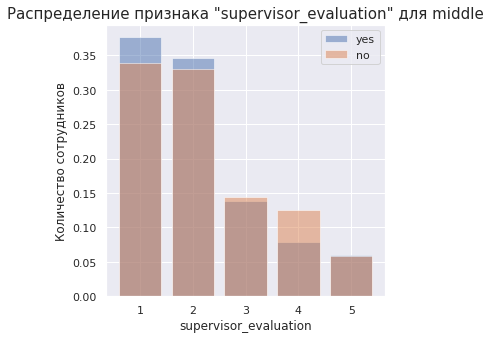

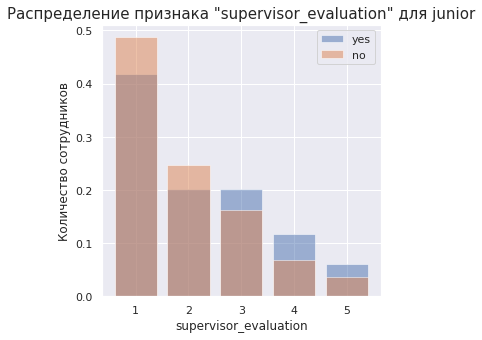

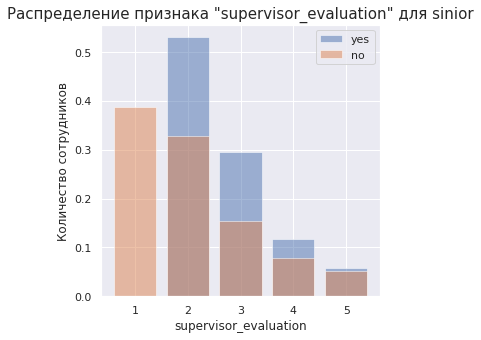

In [69]:
for level in train_quit['level'].unique():
    build_bar(train_quit, 'supervisor_evaluation', level, 'Количество сотрудников')

Для сотрудников уровня middle и sinior увольнения не зависят от оценки руководителя. Сотрудники уровня junior чаще увольняются при оценке 3 балла и ниже.

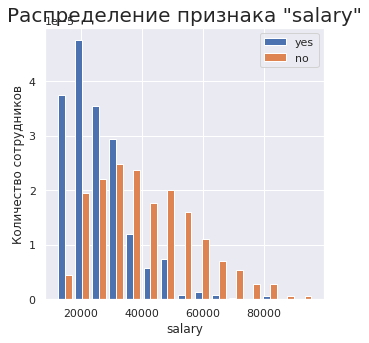

In [70]:
plt.hist(x = [train_quit.loc[train_quit['quit'] == 'yes', 'salary'],
                  train_quit.loc[train_quit['quit'] == 'no', 'salary']], bins = 15, density=True)
plt.title(f'Распределение признака "salary"', size=20)
plt.xlabel('salary')
plt.ylabel('Количество сотрудников')
plt.legend(['yes', 'no'])
plt.show()

In [71]:
train_quit.loc[train_quit['quit'] == 'yes', 'salary'].mean()

25767.93893129771

In [72]:
train_quit.loc[train_quit['quit'] == 'no', 'salary'].mean()

40952.17391304348

Сотрудники с низкой зарплатой увольняются чаще, чем с высокой. Средняя з/п уволившихся сотрудников - 25800, у остальных - 41000.

In [73]:
job_sat = pipeline.predict(train_quit[X])
train_quit['job_satisfaction_rate'] = job_sat

In [74]:
test_merge = test_feature[X].join(target, how='left')
test_merge = test_merge.join(test_quit, how='left')
test_merge

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80,no
100480,marketing,junior,low,4,no,no,4,16800,0.84,no
100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
100610,sales,middle,medium,5,no,no,4,43200,0.75,no
100692,sales,middle,high,6,no,no,4,48000,0.69,no
...,...,...,...,...,...,...,...,...,...,...
997290,sales,sinior,medium,7,no,no,4,58800,0.79,no
998548,marketing,junior,medium,2,no,no,4,32400,0.76,yes
998762,technology,junior,low,3,no,no,3,22800,0.48,yes


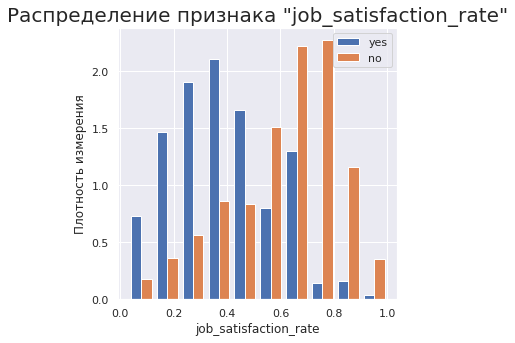

In [75]:
plt.hist(x = [test_merge.loc[test_merge['quit'] == 'yes', 'job_satisfaction_rate'],
                  test_merge.loc[test_merge['quit'] == 'no', 'job_satisfaction_rate']], bins = 10, density=True)
plt.title(f'Распределение признака "job_satisfaction_rate"', size=20)
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Плотность измерения')
plt.legend(['yes', 'no'])
plt.show()

- чаще всего увольняются сотрудники с job_satisfaction_rate равным 0.3 и менее;
- сотрудники с job_satisfaction_rate больше 0.6 увольняются редко.

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

Посмотрим распределение предсказанного целевого признака для тренировочных данных.

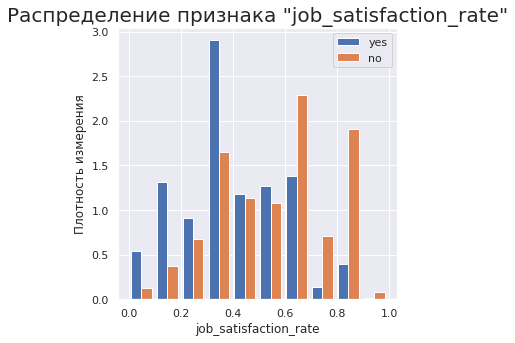

In [76]:
plt.hist(x = [train_quit.loc[train_quit['quit'] == 'yes', 'job_satisfaction_rate'],
                  train_quit.loc[train_quit['quit'] == 'no', 'job_satisfaction_rate']],
   bins = 10, density=True)
plt.title(f'Распределение признака "job_satisfaction_rate"', size=20)
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Плотность измерения')
plt.legend(['yes', 'no'])
plt.show()

**Портрет уволившегося сотрудника:**
- уровень занимаемой должности: junior;
- отсутствие повышений за последний год;
- низкий уровень з/п (среднее значение для уволившихся сотрудников менее 26000);
- оценка руководителем 3 и ниже;
- уровень загрузки low или medium;
- работа в компании менее 3 лет;
- низкий уровень удовлетворенности работой в компании.

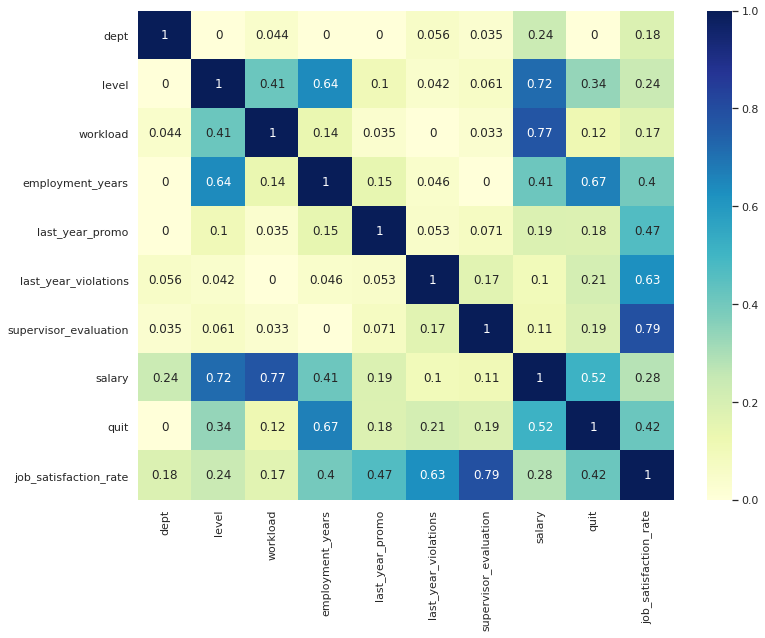

In [77]:
sns.set(rc={'figure.figsize':(12,9)})
interval_cols = ['salary', 'job_satisfaction_rate']
sns.heatmap(train_quit.phik_matrix(interval_cols=interval_cols), cmap="YlGnBu", annot=True)
plt.show()

Целевой признак имеет высокую корреляцию с employment_years, salary и job_satisfaction_rate. Низкая корреляция с признаком dept.

### Подготовка данных

Для предсказания увольнения сотрудников возьмем все признаки, кроме отдела. Выполним кодировку целевого признака.

In [78]:
X_train_2 = train_quit.drop(['quit', 'dept'], axis=1)
y_train_2 = train_quit['quit']

In [79]:
le = LabelEncoder()
y_train_2 = le.fit_transform(y_train_2)

No закодировано как 0, yes - 1.

Добавим к количественным колонкам job_satisfaction_rate

In [80]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Подготовка данных будет осуществляться с помощью пайплайна из предыдущей задачи. 

In [81]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

In [82]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

params = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]

random_search = RandomizedSearchCV(
    pipe_final, 
    params, 
    cv=3,
    random_state = RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=20
)
random_search.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                           

Лучшие результаты на тренировочной выборке дает модель LogisticRegression(C=3, penalty='l1', solver='liblinear'), масштабирование количественных признаков при помощи StandardScaler. Оценка ROC-AUC на кросс-валидации 0.9.  

In [83]:
X_test_2 = test_feature.drop('dept', axis=1)

In [84]:
y_test_2 = le.transform(test_quit['quit'])

Обучим модель CatBoostClassifier. Для подготовки данных заполним пропуски в тестовом датафрейме.

In [85]:
y = ['quit']
X = [col for col in train_quit if col not in y]

In [86]:
else_column = [['employment_years'], ['supervisor_evaluation'], ['salary'], ['job_satisfaction_rate']]

In [87]:
num_category = gen_features(
    columns=else_column,
    classes=[

    ]
)

num_category = [(col_name[0], col_name[1], {"alias": col_name[0][0]}) for col_name in num_category]

In [88]:
preprocess_mapper = DataFrameMapper(
    [
        *gen_category,
        *num_category
    ],
    input_df=True,
    df_out=True
)

In [89]:
params = {
    'iterations': 1000,
    'learning_rate': 0.005,
    'eval_metric': 'AUC',
    'random_seed': RANDOM_STATE,
    'loss_function': 'Logloss',
    'verbose': 100
    
}

In [90]:
pipeline = Pipeline(steps=[
    ("preprocess", preprocess_mapper),
    ("estimator", QuitClassifier(**params))
])

pipeline.fit(train_quit[X], y_train_2, estimator__cat_features=cat_f)

0:	total: 5.47ms	remaining: 5.46s
100:	total: 344ms	remaining: 3.06s
200:	total: 688ms	remaining: 2.73s
300:	total: 1.03s	remaining: 2.39s
400:	total: 1.37s	remaining: 2.05s
500:	total: 1.72s	remaining: 1.71s
600:	total: 2.06s	remaining: 1.37s
700:	total: 2.4s	remaining: 1.02s
800:	total: 2.72s	remaining: 676ms
900:	total: 3.04s	remaining: 334ms
999:	total: 3.35s	remaining: 0us


Pipeline(steps=[('preprocess',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['last_year_violations'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'last_year_violations'}),
                                           (['last_year_promo'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'last_year_promo'}),
                                           (['dept'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'dept'}),
                                           (['wo...
                                            [SimpleImputer(strategy='most_frequent')],
                                            {'alias': 'level'}),
                                           (['employment_years'], None,
                                            {'alias': 'employment_years'}),
                                           (['supervisor_evaluation'], None,
                                            {'alias': 'supervisor_evaluation'}),
                                           (['salary'], None,
                                            {'alias': 'salary'}),
                                           (['job_satisfaction_rate'], None,
                                            {'alias': 'job_satisfaction_rate'})],
                                 input_df=True)),
                ('estimator',
                 <catboost.core.CatBoostClassifier object at 0x7fe7e56c4910>)])

In [94]:
cv_data = cv(
    params=params,
    pool=Pool(pipeline['preprocess'].transform(train_quit[X]), train_quit[y], cat_features=cat_f),
    fold_count=5, 
    shuffle=True,
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]['test-AUC-mean']

Training on fold [0/5]

bestTest = 0.9408643509
bestIteration = 807

Training on fold [1/5]

bestTest = 0.9287926307
bestIteration = 709

Training on fold [2/5]

bestTest = 0.9286477079
bestIteration = 708

Training on fold [3/5]

bestTest = 0.9188486335
bestIteration = 616

Training on fold [4/5]

bestTest = 0.9023454495
bestIteration = 964



778    0.923615
Name: test-AUC-mean, dtype: float64

Оценка модели на кросс-валидации 0.92.

In [93]:
train_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.655065
814010,sales,junior,medium,2,no,no,4,27600,no,0.841080
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.345829
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.331176
910140,marketing,junior,medium,2,no,no,5,25200,no,0.741888
...,...,...,...,...,...,...,...,...,...,...
778735,technology,junior,low,2,no,no,4,22800,yes,0.818351
106936,marketing,junior,low,1,no,no,5,18000,no,0.825321
775320,technology,junior,high,1,no,no,4,42000,yes,0.563284


In [95]:
predict_quit = pipeline.predict_proba(test_feature)[:,1]

In [96]:
roc_auc_score(y_test_2, predict_quit)

0.9283945998538098

Оценка ROC-AUC данной модели 0.928. Качество работы модели соответствует требованиям к задаче. Выполним анализ распределения предсказаний.

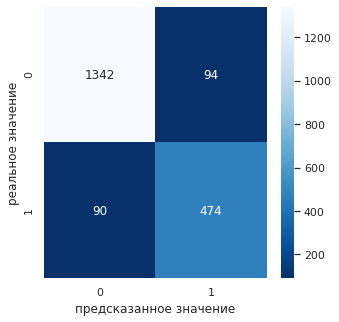

In [97]:
sns.set(rc={'figure.figsize':(5,5)})
cm = confusion_matrix(y_test_2, pipeline.predict(test_feature))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('реальное значение')
plt.xlabel('предсказанное значение')
plt.show()

Модель имеет низкий процент ошибок false positive (FPR = 6.5%) и FNR = 16%. Нас это не устраивает, так как ошибки второго рода являются более критичными, так как внезапные увольнения несут в себе риски для компании. 

Найдем порог классификации, при котором FNR будет около 10%.

0.3


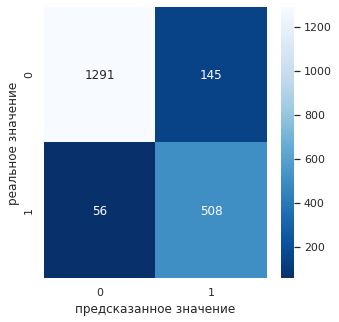

0.32


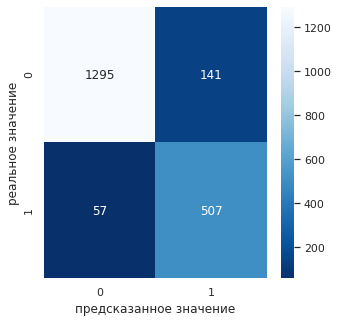

0.34


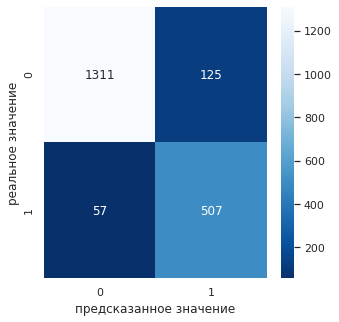

0.36


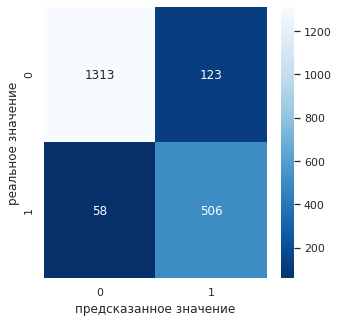

0.38


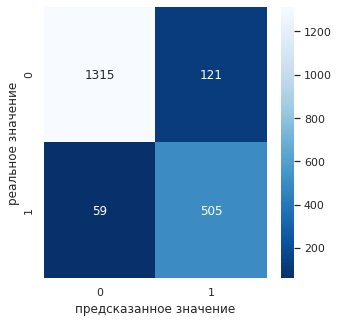

0.4


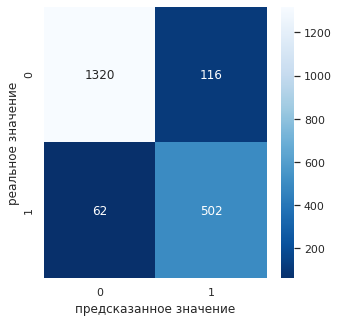

0.42


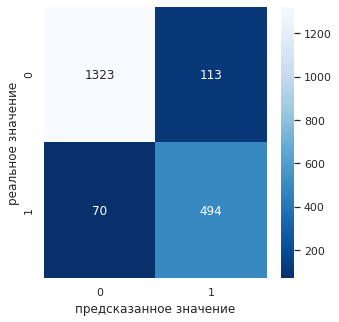

0.44


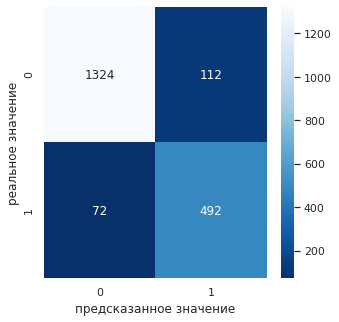

0.46


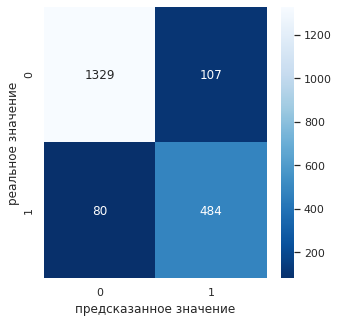

0.48


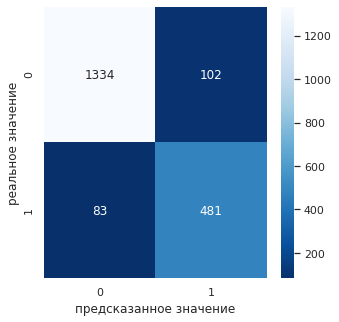

In [98]:
thresholds = [round(i,2) for i in np.linspace(0.3,0.5,num = 10,endpoint=False)]

for i in thresholds:
    print(i)
    sns.set(rc={'figure.figsize':(5,5)})
    cm = confusion_matrix(y_test_2, pipeline.predict_proba(test_feature)[:,1] > i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('реальное значение')
    plt.xlabel('предсказанное значение')
    plt.show()

При thresholds = 0.36 FPR = 8.5%, a FNR = 10.2%. Ошибка первого рода выросла незначительно, зато вероятность ошибки второго рода снизилась на 6%.

### Выводы

Лучше с задачей классификации справилась модель CatBoostClassifier. Для минимизации ошибки второго рода (ложноотрицательных предсказаний) выбран порог классификации равный 0.38

## Итоговые выводы

Были рассмотрены характеристики сотрудников компании. Задачей было на основании данных характеристик научиться предсказывать уровень удовлетворённости сотрудника работой в компании, а также то, что сотрудник уволится из компании.

На первом этапе была проведена работа с признаками: dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary и целевым признаком job_satisfaction_rate.

Данные были загружены в датафреймы pandas, в таблице с тренировочными данными устранены дубликаты. Затем проведен исследовательский анализ, который показал, что:
- 42% сотрудников работают в компании всего 1-2 года;
- 70% сотрудников оценены руководителем на 3-4 балла, только 5% сотрудников имеют оценку "1";
- медианная зарплата сотрудников 31200. 10% сотрудников получают зарплату ниже 18000, 10% - выше 56400;
- почти 90% значений целевого признака лежат в диапазоне 0.2 - 0.9;
- level и employment_years имеют линейную взаимосвязь;
- зарплата сотрудников уровня в среднем junior меньше, чем у сотрудников уровня middle. Самые высокие зарплаты у сотрудников с уровнем sinior.
- зарплата у сотрудников с высоким уровнем загруженности больше, чем у сотрудников со средним и низким;
- больше всего повышений получили сотрудники, работающие в компании 5-6 лет;
- для каждой выставленной руководителем оценки наибольший уровень удовлетворенности работой имеют те сотрудники, у которых было повышение за последний год;
- люди, нарушавшие трудовой договор в течение последнего года имеют более низкий уровень удовлетворенности работой в компании;
- с повышением оценки руководителя увеличивается уровень удовлетворенности сотрудников работой;
- уровень заработной платы в целом не влияет на целевой признак, однако, при очень низкой зарплате нет высоких показателей job_satisfaction_rate, а при высокой з/п нет низких показателей job_satisfaction_rate;
- у сотрудников с большим значением employment_years отсутствуют экстремально низкие показатели целевого признака.
- целевой признак имеет сильную корреляцию с признакам supervisor_evaluation и last_year_violation. С признаками dept, level, workload корреляция слабая. Мультиколлинеарности в данных нет.
Для кодирования категориальных переменных был использованы OneHotEncoder (для признаков last_year_violations и last_year_promo) и OrdinalEncoder (для признаков workload и level). Перед кодированием выполняется работа с пропусками - замена их на самое популярное значение в данном столбце при помощи SimpleImputer. Для числовых колонок с помощью RandomizedSearchCV подбирается оптимальная стратегия: масштабирование с помощью StandardScaler, MinMaxScaler или отсутствие масштабирования. 

Лучшей моделью в пайплайне выбрана DecisionTreeRegressor(max_depth=8, max_features=7, max_leaf_nodes=77). Оценка на тренировочной выборке 17.6. 

Также была обучена модель CatBoostRegressor, которая дала оценку SMAPE = 10.8 на тестовой выборке. Гистограмма распределения остатков для данной модели показала распределение, близкое к нормальному с центром в нуле. На графике дисперсии равномерное распределение ошибок предсказания. В 90% случаев остатки находятся в диапазоне от -0.1 до 0.1. Что говорит о стабильной хорошей работе модели. Наиболее важными признаками являются supervisor_evaluation, employment_years и salary. Данные признаки имеют прямую зависимость с целевым. Таким образом, сотрудники с высокой оценкой от руководителя, длительным сроком работы и высоким уровнем з/п имеют более высокую удовлетворенность работой в компании.

Во второй части работы к характеристикам сотрудников добавился предсказанный моделью уровень job_satisfaction_rate, а целевым признаком стал quit. Аналогично были проведены загрузка и предобработка данных.

Данные исследовательского анализа:
- чаще всего из компании увольняются сотрудники с уровнем junior;
- сотрудники, у которых было повыщение за последний год, обычно не увольняются;
- сотрудники с высокой нагрузкой реже увольняются. Скорее всего это связано с уровнем зарплаты;
- среди уволившихся сотрудников выше процент имеющих нарушения трудового договора за последний год;
- сотрудники равномерно удаляются из всех отделов;
- чаще увольняются сотрудники, проработавшие не более 3 лет;
- для сотрудников уровня middle и sinior увольнения не зависят от оценки руководителя. Сотрудники уровня junior чаще увольняются при оценке 3 балла и ниже;
- сотрудники с низкой зарплатой увольняются чаще, чем с высокой. Средняя з/п уволившихся сотрудников - 25800, у остальных - 41000;
- чаще всего увольняются сотрудники с job_satisfaction_rate равным 0.3 и менее;
- сотрудники с job_satisfaction_rate больше 0.6 увольняются редко;
- целевой признак имеет высокую корреляцию с employment_years, salary и job_satisfaction_rate. Низкая корреляция с признаком dept.

Составлен портрет уволившегося сотрудника:
- уровень занимаемой должности: junior;
- отсутствие повышений за последний год;
- низкий уровень з/п (среднее значение для уволившихся сотрудников менее 26000);
- оценка руководителем 3 и ниже;
- уровень загрузки low или medium;
- работа в компании менее 3 лет;
- низкий уровень удовлетворенности работой в компании.

В пайплайне были обучены модели DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression, для них подобраны гиперпараметры. Лучшей моделью является LogisticRegression(C=3, penalty='l1', solver='liblinear'). Ее оценка ROC-AUC на тренировочной выборке 0.9.

Обучена модель CatBoostClassifier, ее оценка ROC-AUC на тренировочной выборке 0.928. Для данной модели подобран порог классификации 0.38 для уменьшения ошибки второго рода (предсказание того, что уволившийся сотрудник останется в компании).

Так как чаще всего увольняются сотрудники с маленькой заработной платой и низким уровнем загрузки, можно увеличить нагрузку на сотрудника и за это платить бОльшую сумму. Также сотрудники очень позитивно относятся к повышениям - можно проводить незначительные повышения для увеличения лояльности к компании. Если есть цель уменьшить текучку молодых сотрудников (чаще всего увольняются джуны), то можно рассмотреть для них программу бонусов: выплата "подъемных", ссуды на обустройство и т.п., которые обязуют сотрудников отработать определенный минималыный срок в компании.